In [ ]:
from numpy import zeros
from numpy import ones
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from tensorflow.keras.layers import Input,Conv2D,Conv2DTranspose,LeakyReLU,Activation,Concatenate,Dropout,BatchNormalization
from matplotlib import pyplot as plt
from tensorflow.keras.utils import plot_model
import numpy as np
import pandas as pd
import os
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import re

In [ ]:
def define_discriminator(image_shape):

    # weight initialization
    init = RandomNormal(stddev=0.02)

    # source image input
    in_src_image = Input(shape=image_shape)  #Image we want to convert to another image
    # target image input
    in_target_image = Input(shape=image_shape)  #Image we want to generate after training.

    # concatenate images, channel-wise
    merged = Concatenate()([in_src_image, in_target_image])

    # C64: 4x4 kernel Stride 2x2
    d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
    d = LeakyReLU(alpha=0.2)(d)
    # C128: 4x4 kernel Stride 2x2
    d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # C256: 4x4 kernel Stride 2x2
    d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # C512: 4x4 kernel Stride 2x2
    # Not in the original paper. Comment this block if you want.
    d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)

    # patch output
    d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
    patch_out = Activation('sigmoid')(d)
    # define model
    model = Model([in_src_image, in_target_image], patch_out)
    # compile model
    #The model is trained with a batch size of one image and Adam opt.
    #with a small learning rate and 0.5 beta.
    #The loss for the discriminator is weighted by 50% for each model update.

    opt = Adam(learning_rate=0.0003, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
    return model

In [ ]:
def define_encoder_block(layer_in, n_filters, batchnorm=True):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # add downsampling layer
    g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
    # conditionally add batch normalization
    if batchnorm:
        g = BatchNormalization()(g, training=True)
    # leaky relu activation
    g = LeakyReLU(alpha=0.2)(g)
    return g


In [ ]:
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # add upsampling layer
    g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
    # add batch normalization
    g = BatchNormalization()(g, training=True)
    # conditionally add dropout
    if dropout:
        g = Dropout(0.5)(g, training=True)
    # merge with skip connection
    g = Concatenate()([g, skip_in])
    # relu activation
    g = Activation('relu')(g)
    return g

In [ ]:
def define_generator(image_shape=(256,256,3)):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # image input
    in_image = Input(shape=image_shape)
    # encoder model: C64-C128-C256-C512-C512-C512-C512
    e1 = define_encoder_block(in_image, 64, batchnorm=False)
    e2 = define_encoder_block(e1, 12)
    e3 = define_encoder_block(e2, 256)
    e4 = define_encoder_block(e3, 512)
    e5 = define_encoder_block(e4, 512)
    e6 = define_encoder_block(e5, 512)
    e7 = define_encoder_block(e6, 512)
    # bottleneck, no batch norm and relu
    b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
    b = Activation('relu')(b)
    # decoder model: CD512-CD512-CD512-C512-C256-C128-C64
    d1 = decoder_block(b, e7, 512)
    d2 = decoder_block(d1, e6, 512)
    d3 = decoder_block(d2, e5, 512)
    d4 = decoder_block(d3, e4, 512, dropout=False)
    d5 = decoder_block(d4, e3, 256, dropout=False)
    d6 = decoder_block(d5, e2, 128, dropout=False)
    d7 = decoder_block(d6, e1, 64, dropout=False)
    # output
    g = Conv2DTranspose(image_shape[2], (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7) #Modified
    out_image = Activation('tanh')(g)  #Generates images in the range -1 to 1. So change inputs also to -1 to 1
    # define model
    model = Model(in_image, out_image)
    return model

In [ ]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model, image_shape):
    # make weights in the discriminator not trainable
    for layer in d_model.layers:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = False       #Descriminator layers set to untrainable in the combined GAN but
                                                #standalone descriminator will be trainable.

    # define the source image
    in_src = Input(shape=image_shape)
    # suppy the image as input to the generator
    gen_out = g_model(in_src)
    # supply the input image and generated image as inputs to the discriminator
    dis_out = d_model([in_src, gen_out])
    # src image as input, generated image and disc. output as outputs
    model = Model(in_src, [dis_out, gen_out])
    # compile model
    opt = Adam(learning_rate=0.0002, beta_1=0.5)

    #Total loss is the weighted sum of adversarial loss (BCE) and L1 loss (MAE)
    #Authors suggested weighting BCE vs L1 as 1:100.
    model.compile(loss=['binary_crossentropy', 'mae'],
               optimizer=opt, loss_weights=[1,100])
    return model

In [ ]:
# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
    # unpack dataset
    trainA, trainB = dataset
    # choose random instances
    ix = randint(0, trainA.shape[0], n_samples)
    # retrieve selected images
    X1, X2 = trainA[ix], trainB[ix]
    # generate 'real' class labels (1)
    y = ones((n_samples, patch_shape, patch_shape, 1))
    return [X1, X2], y


In [ ]:
# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape):
    # generate fake instance
    X = g_model.predict(samples)
    # create 'fake' class labels (0)
    y = zeros((len(X), patch_shape, patch_shape, 1))
    return X, y


In [ ]:
def summarize_performance(step, g_model, dataset, n_samples=3):
    # select a sample of input images
    [X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
    # generate a batch of fake samples
    X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
    # scale all pixels from [-1,1] to [0,1]
    X_realA = (X_realA + 1) / 2.0
    X_realB = (X_realB + 1) / 2.0
    X_fakeB = (X_fakeB + 1) / 2.0
    # plot real source images
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + i)
        plt.axis('off')
        plt.imshow(X_realA[i])
    # plot generated target image
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + n_samples + i)
        plt.axis('off')
        plt.imshow(X_fakeB[i])
    # plot real target image
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + n_samples*2 + i)
        plt.axis('off')
        plt.imshow(X_realB[i])
    # save plot to file
    filename1 = 'plot_%06d.png' % (step+1)
    plt.savefig(filename1)
    plt.close()
    # save the generator model
    filename2 = 'model_%06d.h5' % (step+1)
    g_model.save(filename2)
    print('>Saved: %s and %s' % (filename1, filename2))


In [ ]:
def train(d_model, g_model, gan_model, dataset, n_epochs=100, n_batch=1):

    n_patch = d_model.output_shape[1]

    trainA, trainB = dataset
    # calculate the number of batches per training epoch
    bat_per_epo = int(len(trainA) / n_batch)
    n_steps = bat_per_epo * n_epochs
    d1=[]
    d2=[]
    g=[]
    for i in range(n_steps):
        # select a batch of real samples
        [X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
        # generate a batch of fake samples
        X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
        # update discriminator for real samples
        d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real) # Model([in_src_image, in_target_image], patch_out)
        d1.append(d_loss1)
        # update discriminator for generated samples
        d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)  # Model([in_src_image, in_target_image], patch_out)
        d2.append(d_loss2)
        # update the generator
        g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB]) # Model(in_src, [dis_out, gen_out])
        g.append(g_loss)
        # summarize performance
        print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
        # summarize model performance
        if (i+1) % (bat_per_epo * 3) == 0:
            summarize_performance(i, g_model, dataset)
    steps = np.arange(1,n_steps+1)
    return steps,d1,d2,g



In [ ]:
IMG_SIZE=256

In [ ]:
def create_dataset():
    happy = []
    happy_labels = []

    files_list1 = os.listdir(r"C:\Users\ASUS\Desktop\project-faceexp\model1data\happy")
    for file_name in (files_list1):
        path=("C:/Users/ASUS/Desktop/project-faceexp/model1data/happy"+"/" + file_name)
        img=cv2.imread(path)

        image=cv2.resize(img,(IMG_SIZE,IMG_SIZE))

        happy.append(np.array(image))
        happy_labels.append(file_name)


    nuetral= []
    nuetral_labels = []

    files_list3 = os.listdir(r"C:\Users\ASUS\Desktop\project-faceexp\model1data\nuetral")
    for file_name in sorted(files_list3):
        path=(r"C:\Users\ASUS\Desktop\project-faceexp\model1data\nuetral"+"/" +file_name)
        img=cv2.imread(path)

        image2=cv2.resize(img,(IMG_SIZE,IMG_SIZE))
        nuetral.append(np.array(image2))
        nuetral_labels.append(file_name)


    nuetral = np.asarray(nuetral)
    happy = np.asarray(happy)
    nuetral_labels = np.array( nuetral_labels)
    happy_labels = np.array( happy_labels)
    return nuetral,happy,happy_labels,nuetral_labels

In [ ]:
nuetral,happy,happy_labels,nuetral_labels=create_dataset()


In [ ]:
print(happy.shape)
print(nuetral.shape)

(100, 256, 256, 3)
(100, 256, 256, 3)


In [ ]:
def visual(index):
    plt.subplot(1, 2, 1)
    rgb = cv2.cvtColor(nuetral[index], cv2.COLOR_BGR2RGB)
    plt.imshow(rgb, cmap = plt.cm.Spectral)
    plt.xlabel(nuetral_labels[index])


    plt.subplot(1, 2, 2)
    rgb = cv2.cvtColor(happy[index], cv2.COLOR_BGR2RGB)
    plt.imshow(rgb, cmap = plt.cm.Spectral)
    plt.xlabel(happy_labels[index])


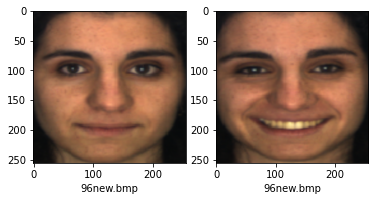

In [ ]:
visual(95)

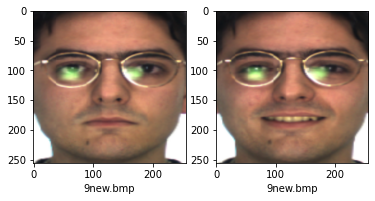

In [ ]:
visual(99)

In [ ]:
trainn=nuetral[:95]
trainh=happy[:95]
testn=nuetral[95:]
testh=happy[95:]

In [ ]:
np.random.seed(99)


image_shape = trainn.shape[1:]

d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)

gan_model = define_gan(g_model, d_model, image_shape)



C:\Users\ASUS\Anaconda3\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [ ]:
def preprocess_data(data):

    X1, X2 = data[0], data[1]
    # scale from [0,255] to [-1,1]
    X1 = (X1 - 127.5) / 127.5
    X2 = (X2 - 127.5) / 127.5
    return [X1, X2]


In [ ]:
happy[1].shape

(256, 256, 3)

In [ ]:
trainn.shape

(95, 256, 256, 3)

In [ ]:

data = [trainn, trainh]
dataset = preprocess_data(data)

In [ ]:
from datetime import datetime
start1 = datetime.now()

steps,d_loss1,d_loss2,g_loss=train(d_model, g_model, gan_model, dataset, n_epochs=5, n_batch=1)

stop1 = datetime.now()
#Execution time of the model
execution_time = stop1-start1
print("Execution time is: ", execution_time)

1/1 [==============================] - 0s 126ms/step
>1, d1[0.222] d2[0.218] g[27.374]
1/1 [==============================] - 0s 133ms/step
>2, d1[0.182] d2[0.228] g[21.618]
1/1 [==============================] - 0s 125ms/step
>3, d1[0.160] d2[0.179] g[20.795]
1/1 [==============================] - 0s 141ms/step
>4, d1[0.303] d2[0.363] g[25.840]
1/1 [==============================] - 0s 125ms/step
>5, d1[0.423] d2[0.267] g[22.080]
1/1 [==============================] - 0s 125ms/step
>6, d1[0.225] d2[0.294] g[23.511]
1/1 [==============================] - 0s 179ms/step
>7, d1[0.180] d2[0.497] g[22.787]
1/1 [==============================] - 0s 125ms/step
>8, d1[0.209] d2[0.299] g[17.810]
1/1 [==============================] - 0s 125ms/step
>9, d1[0.233] d2[0.292] g[22.743]
1/1 [==============================] - 0s 141ms/step
>10, d1[0.258] d2[0.162] g[21.381]
1/1 [==============================] - 0s 125ms/step
>11, d1[0.134] d2[0.257] g[27.711]
1/1 [==============================] - 0s

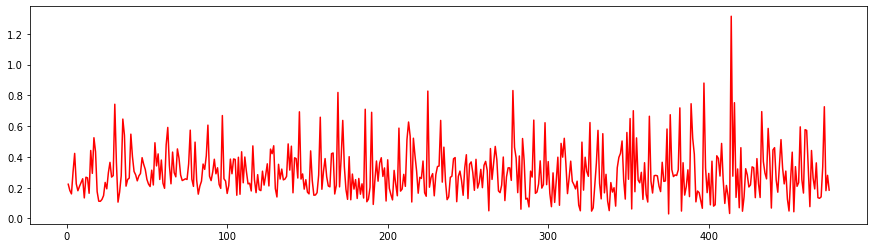

In [ ]:
f = plt.figure()
f.set_figwidth(15)
plt.plot(steps, d_loss1, 'red', label = 'd_loss1')


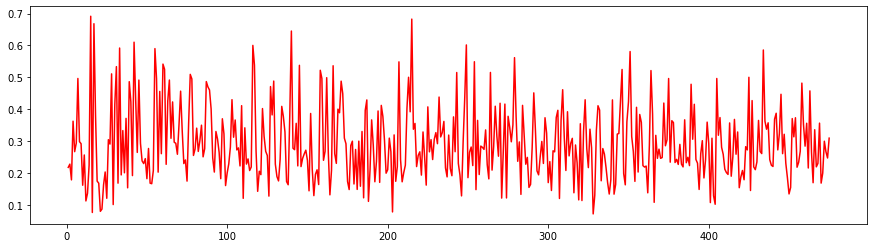

In [ ]:
f = plt.figure()
f.set_figwidth(15)
plt.plot(steps, d_loss2, 'red', label = 'd_loss2')

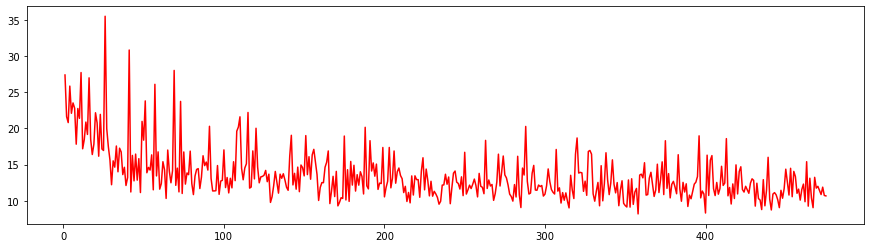

In [ ]:
f = plt.figure()
f.set_figwidth(15)
plt.plot(steps, g_loss, 'red', label = 'g_loss')

In [ ]:
nuetral,happy,happy_labels,nuetral_labels=create_dataset()




In [ ]:
y_test=happy[95:]

X_test=nuetral[95:]

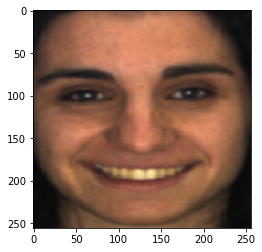

In [ ]:

rgb = cv2.cvtColor(y_test[0], cv2.COLOR_BGR2RGB)
plt.imshow(rgb, cmap = plt.cm.Spectral)



In [ ]:
data = [X_test,y_test]
def preprocess_data(data):
    X1, X2 = data[0], data[1]
    # scale from [0,255] to [-1,1]
    X1 = (X1 - 127.5) / 127.5
    X2 = (X2 - 127.5) / 127.5
    return [X1, X2]

dataset = preprocess_data(data)

In [ ]:



#unpreprocess
def show(img):
    ax = plt.gca()
    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])
    img = np.float32(img)

    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(((rgb* 127.5) + 127.5).astype(np.uint8))


In [ ]:

[X1, X2] = dataset

In [ ]:
gen_photos=[]




[X1, X2] = dataset

for i in range(0,5):

    src_image, tar_image = X1[[i]], X2[[i]]


    gen_image = g_model.predict(src_image)

    gen_photos.append(np.array(gen_image))

gen_photos=np.array(gen_photos)

1/1 [==============================] - 0s 125ms/step


In [ ]:
gen_photos.shape

(5, 1, 256, 256, 3)

In [ ]:
gen_photos.resize( 5,256, 256, 3)

In [ ]:
def visualize(index):

    plt.subplot(1, 3, 1)
    img = X1[index]
    plt.xlabel("source")
    show(img)


    plt.subplot(1, 3, 2)
    show(X2[index])
    plt.xlabel("target")

    plt.subplot(1, 3, 3)
    img=gen_photos[index]
    plt.xlabel("generated")


    show(img)

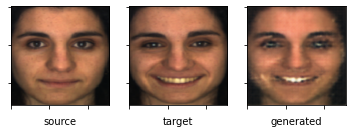

In [ ]:
visualize(0)

Text(0.5, 0, 'generated')

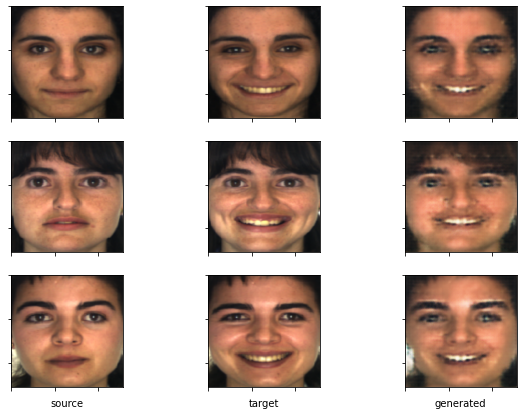

In [ ]:
import cv2
from matplotlib import pyplot as plt

# create figure
fig = plt.figure(figsize=(10, 7))

rows = 3
columns = 3

Image1 = X1[0]
Image2 = X2[0]
Image3 = gen_photos[0]
Image4 =  X1[3]
Image5 = X2[3]
Image6 = gen_photos[3]
Image7 = X1[2]
Image8 = X2[2]
Image9 = gen_photos[2]

fig.add_subplot(rows, columns, 1)

show(Image1)


fig.add_subplot(rows, columns, 2)

show(Image2)


fig.add_subplot(rows, columns, 3)


show(Image3)


fig.add_subplot(rows, columns, 4)

show(Image4)

fig.add_subplot(rows, columns, 5)


show(Image5)

fig.add_subplot(rows, columns, 6)

show(Image6)

fig.add_subplot(rows, columns, 7)

show(Image7)
plt.xlabel("source")
fig.add_subplot(rows, columns, 8)

show(Image8)
plt.xlabel("target")
fig.add_subplot(rows, columns, 9)

show(Image9)
plt.xlabel("generated")